In [1]:
# !pip install scikit-uplift
# !pip install catboost
# !pip install causalml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 648 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 20 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 535 kB 6.4 MB/s 
     |████████████████████████████████| 76 kB 4.9 MB/s 
     |████████████████████████████████| 569 kB 19.6 MB/s 
     |████████████████████████████████| 1.8 MB 38.6 MB/s 
     |████████████████████████████████| 722 kB 37.9 MB/s 
     |████████████████████████████████| 115 kB 53.6 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 110 kB 64.1 MB/s 
  Created wheel for causalml: filename=causalml-0.13.0-cp37-cp37m-linux_x86_64.whl size=1293704 sha256=c8064933135803b2c6fe04f372b6

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from IPython.display import Image

from scipy.stats import norm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklift.models import SoloModel, TwoModels, ClassTransformation
from sklift.metrics import uplift_at_k, uplift_by_percentile  # для проверки ручного разбиения
from sklift.viz import plot_uplift_preds

from catboost import CatBoostClassifier

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_plot, uplift_tree_string

warnings.filterwarnings('ignore')
%matplotlib inline

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/hw_data/'

Mounted at /content/drive


__1. скачать набор данных маркетинговых кампаний отсюда__ https://www.kaggle.com/davinwijaya/customer-retention

__2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.__

In [4]:
data = pd.read_csv(path + 'data.csv', sep=',')
# data = pd.read_csv('data.csv', sep=',')
data.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [5]:
# переименование
data.rename(columns={'conversion': 'target', 'offer':'treatment'}, inplace=True)
data.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [6]:
# для проверки
data['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [7]:
data

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [8]:
# замена
data['treatment'] = data['treatment'].map(lambda x: 0 if x == 'No Offer' else 1)
data.treatment.value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

__3. сделать разбиение набора данных на тренировочную и тестовую выборки__

In [9]:
# data.info()

In [10]:
indices_learn, indices_valid = train_test_split(data.index, test_size=0.3, random_state=42)

In [11]:
# экспериментальная группа
X_train = data.drop(['treatment', 'target'], axis=1).loc[indices_learn, :]  # features
# чтобы вернуть df = .loc[[]]
y_train = data.loc[indices_learn, 'target']  # Y = 1/0
treat_train = data.loc[indices_learn, 'treatment']  # W = 1/0

# контрольная группа
X_val = data.drop(['treatment', 'target'], axis=1).loc[indices_valid, :]
y_val = data.loc[indices_valid, 'target']
treat_val = data.loc[indices_valid, 'treatment']

In [12]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, treat_train.shape, treat_val.shape

((44800, 7), (19200, 7), (44800,), (19200,), (44800,), (19200,))

причём тестовая - именно контрольная, а не валидационная, те hold-out
или эксперимент и контроль?
всё-таки тест нужен
тест - это конкретно тест!
но данных мало
делаю, короче, как в методичке!
нет, тестовая именно валидационная, шпарим как в методичке!
а как феат инж? на какой выборке учить? только на эксперименте, видимо

__4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)__

#### Признаки:
- **recency** - число месяцев с последней покупки
- **history** - $, стоимость покупок (накопительная?)
- **used_discount** - использовал ли ранее скидку, бинарный
- **used_bogo** - использовал ли ранее опцию, бинарный
- **zip_code** - индекс: Suburban/Urban/Rural, категориальный
- **is_referral** - привлечение, бинарный
- **channel** - канал: Phone/Web/Multichannel, категориальный

Пропусков в данных нет.

In [13]:
num_features = ['recency', 'history']
bin_features = ['used_discount', 'used_bogo', 'is_referral']
cat_features = ['zip_code', 'channel']

In [14]:
data['treatment'].value_counts(normalize=True)

1    0.667094
0    0.332906
Name: treatment, dtype: float64

Данные заметно несбалансированные по target.

In [15]:
data['target'].value_counts(normalize=True)

0    0.853219
1    0.146781
Name: target, dtype: float64

In [16]:
data.loc[data['treatment'] == 1, 'target'].value_counts(normalize=True)

0    0.832951
1    0.167049
Name: target, dtype: float64

In [17]:
# масштаб num_features разный
X_train.describe()

,recency,history,used_discount,used_bogo,is_referral
count,44800.000000,44800.000000,44800.000000,44800.000000,44800.000000
mean,5.768705,241.894206,0.550268,0.550424,0.500893
std,3.508044,255.238863,0.497472,0.497456,0.500005
min,1.000000,29.990000,0.000000,0.000000,0.000000
25%,2.000000,64.720000,0.000000,0.000000,0.000000
50%,6.000000,158.205000,1.000000,1.000000,1.000000
75%,9.000000,325.267500,1.000000,1.000000,1.000000
max,12.000000,3215.970000,1.000000,1.000000,1.000000


Распределения числовых признаков:

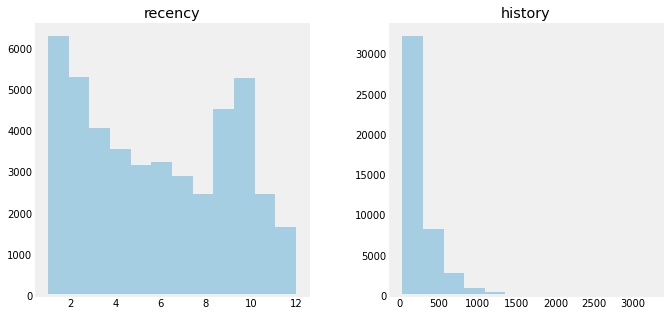

In [18]:
X_train[num_features].hist(figsize=(10, 5), bins=12, grid=False);

Бинарных:

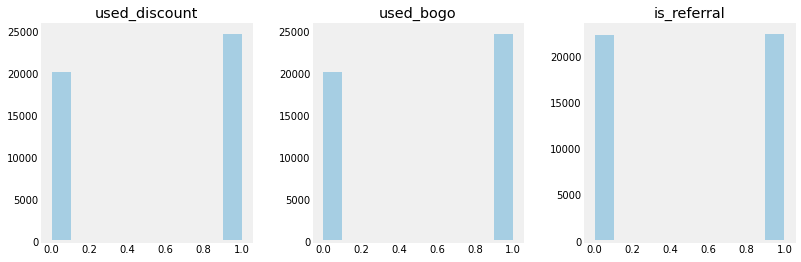

In [19]:
X_train[bin_features].hist(figsize=(12, 4), grid=False, layout=(1, 3));

used_discount и used_bogo подозрительно похожи

Просто чтобы посмотреть - zip_code в ранг: Rural, Surburban, Urban.

In [20]:
X_train_new = X_train.copy()

In [21]:
zip_code_range = {'Rural': 0, 'Surburban': 1, 'Urban':2}
X_train_new['zip_code_r'] = X_train['zip_code'].replace(zip_code_range)

In [22]:
# и категориальные - в бинарные
X_train_new = pd.get_dummies(X_train_new, columns=['zip_code', 'channel'])
X_train_new.head(5)

,recency,history,used_discount,used_bogo,is_referral,zip_code_r,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
9656,7,434.35,1,0,1,2,0,0,1,0,0,1
63037,1,376.59,1,0,0,1,0,1,0,1,0,0
31405,3,140.34,0,1,1,2,0,0,1,0,1,0
58088,3,150.76,0,1,0,1,0,1,0,0,0,1
44344,2,67.97,1,0,1,1,0,1,0,0,1,0


Матрица корреляций: для кодированных категориальных - ожидаемо высокие, но: > abs(0.8) 
- между channel_Phone и channel_Web, 
- zip_code_Urban и zip_code_Suburban, а также 
- used_bogo и used_discount. 

zip_code_r - высокие коррел, но это придуманный признак, те будет отбираться.

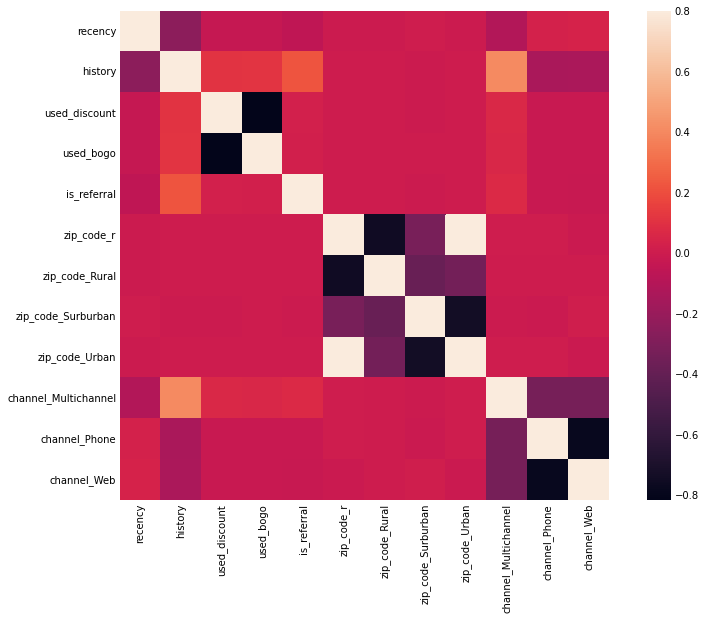

In [23]:
corrmat = X_train_new.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Преобразования для recency: двуглавое распределение

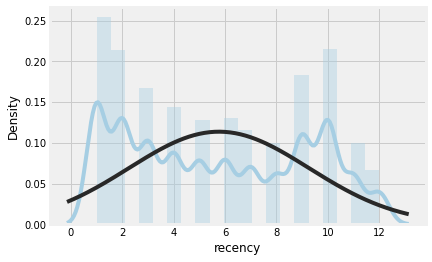

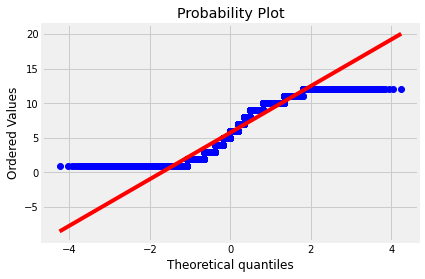

In [24]:
# преобразования для recency - без преобразования
sns.distplot(data['recency'], bins=20, fit=norm)
fig = plt.figure()
res = stats.probplot(data['recency'], plot=plt)

In [25]:
feat_h = FeatureHasher(n_features=2, input_type='string')

x_new = feat_h.fit_transform(X_train_new.loc[:, 'recency'].astype(str)).toarray()
x_new[:3]

array([[ 1.,  0.],
       [ 0., -1.],
       [ 1.,  0.]])

In [26]:
X_train_new = pd.concat([X_train_new, 
                         pd.DataFrame(x_new, columns=['recency_0', 'recency_1']).set_index(X_train_new.index)], 
                        axis=1)
X_train_new.head(5)

,recency,history,used_discount,used_bogo,is_referral,zip_code_r,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,recency_0,recency_1
9656,7,434.35,1,0,1,2,0,0,1,0,0,1,1.0,0.0
63037,1,376.59,1,0,0,1,0,1,0,1,0,0,0.0,-1.0
31405,3,140.34,0,1,1,2,0,0,1,0,1,0,1.0,0.0
58088,3,150.76,0,1,0,1,0,1,0,0,0,1,1.0,0.0
44344,2,67.97,1,0,1,1,0,1,0,0,1,0,0.0,1.0


Преобразования для history:

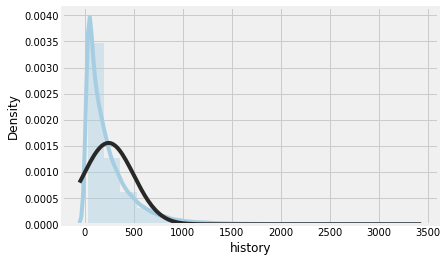

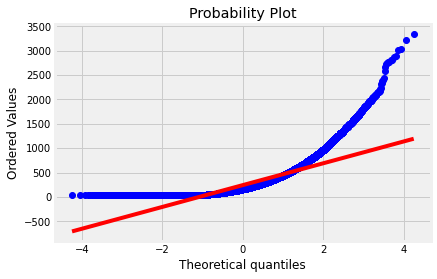

In [27]:
# history - без преобразования
sns.distplot(data['history'], bins=20, fit=norm)
fig = plt.figure()
res = stats.probplot(data['history'], plot=plt)

In [28]:
# sqrt
X_train_new['history_sqrt'] = np.sqrt(X_train_new['history'])

In [29]:
# и log
X_train_new['history_log'] = np.log(X_train_new['history'])

Для used_bogo и used_discount:

In [30]:
# простая сумма
X_train_new['bogo_and_discount'] = X_train_new['used_bogo'] +  X_train_new['used_discount']
X_train_new.head(5)

,recency,history,used_discount,used_bogo,is_referral,zip_code_r,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,recency_0,recency_1,history_sqrt,history_log,bogo_and_discount
9656,7,434.35,1,0,1,2,0,0,1,0,0,1,1.0,0.0,20.841065,6.073851,1
63037,1,376.59,1,0,0,1,0,1,0,1,0,0,0.0,-1.0,19.405927,5.931157,1
31405,3,140.34,0,1,1,2,0,0,1,0,1,0,1.0,0.0,11.846518,4.944068,1
58088,3,150.76,0,1,0,1,0,1,0,0,0,1,1.0,0.0,12.278436,5.015689,1
44344,2,67.97,1,0,1,1,0,1,0,0,1,0,0.0,1.0,8.244392,4.219066,1


#### Простой отбор:

In [31]:
# сперва стандартизация: 
# zip_code_r и 'bogo_and_discount'?
stand_feat = ['recency', 'history', 'zip_code_r', 'history_sqrt', 'history_log', 
              'bogo_and_discount']

stand_sc = StandardScaler()
X_train_new[stand_feat] = stand_sc.fit_transform(X_train_new[stand_feat].values)
X_train_new.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_r,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,recency_0,recency_1,history_sqrt,history_log,bogo_and_discount
9656,0.350996,0.754031,1,0,1,1.078523,0,0,1,0,0,1,1.0,0.0,0.986591,1.048444,-0.334613
63037,-1.359378,0.527730,1,0,0,-0.356177,0,1,0,1,0,0,0.0,-1.0,0.784368,0.909544,-0.334613
31405,-0.789253,-0.397884,0,1,1,1.078523,0,0,1,0,1,0,1.0,0.0,-0.280816,-0.051304,-0.334613
58088,-0.789253,-0.357059,0,1,0,-0.356177,0,1,0,0,0,1,1.0,0.0,-0.219955,0.018413,-0.334613
44344,-1.074316,-0.681425,1,0,1,-0.356177,0,1,0,0,1,0,0.0,1.0,-0.788386,-0.757033,-0.334613


In [32]:
# надо ли его?
X_train_new['treat_train'] = treat_train

In [33]:
# lasso 1 для отбора
lr = LogisticRegression(penalty='l1', C=0.2, solver='saga', random_state=42)

lr.fit(X_train_new, y_train)

y_pred = lr.predict_proba(X_train_new)[:, 1]
roc_auc_score(y_train, y_pred)

0.6442371822896704

In [34]:
features_imp = pd.DataFrame(np.vstack([lr.feature_names_in_, np.abs(lr.coef_[0])]).T, 
                            columns=['feats', 'abs_coeff'])
features_imp.sort_values('abs_coeff', ascending=False)

,feats,abs_coeff
4,is_referral,0.557529
17,treat_train,0.50793
0,recency,0.187083
11,channel_Web,0.181894
7,zip_code_Surburban,0.167942
14,history_sqrt,0.163767
3,used_bogo,0.158852
16,bogo_and_discount,0.15781
5,zip_code_r,0.137801
10,channel_Phone,0.088505


In [35]:
new_features = ['is_referral', 
                 'recency', 
                 'channel_Web', 
                 'zip_code_Surburban', 
                 'history_sqrt', 
                 'used_bogo', 
                 'bogo_and_discount', 
                 'zip_code_r',
                 'channel_Phone']

Снова корреляции

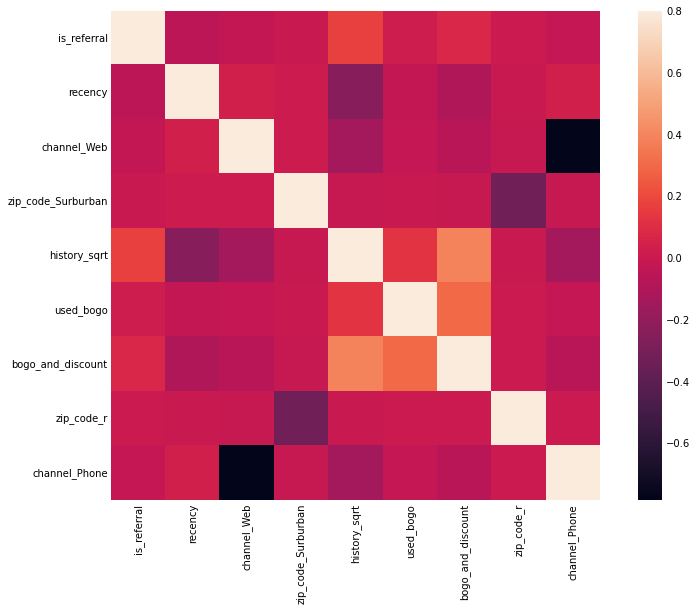

In [36]:
corrmat = X_train_new[new_features].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [37]:
X_train_new[new_features].head()

,is_referral,recency,channel_Web,zip_code_Surburban,history_sqrt,used_bogo,bogo_and_discount,zip_code_r,channel_Phone
9656,1,0.350996,1,0,0.986591,0,-0.334613,1.078523,0
63037,0,-1.359378,0,1,0.784368,0,-0.334613,-0.356177,0
31405,1,-0.789253,0,0,-0.280816,1,-0.334613,1.078523,1
58088,0,-0.789253,1,1,-0.219955,1,-0.334613,-0.356177,0
44344,1,-1.074316,0,1,-0.788386,0,-0.334613,-0.356177,1


#### Пайплайн для обработки признаков.

In [38]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]  # вернёт Series
    
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]  # вернёт DataFrame


# складывает два столбца
class NumericSum(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xp = X[self.key].copy()
        self.columns = f'{self.key[0]}+{self.key[1]}'
    
        Xp[self.columns] = Xp.loc[:, self.key[0]].values + Xp.loc[:, self.key[1]].values        

        return Xp[[self.columns]]  


# создание 1 бинарного признака на основании категориального столбца
class BinEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key, category):
        self.key = key
        self.columns = []
        self.category = category

    def fit(self, X, y=None):
        self.columns = [self.key + '_' + self.category]
        return self

    def transform(self, X):
        self.columns = [self.key + '_' + self.category]
        X = pd.get_dummies(X, prefix=self.key)
        return X[self.columns]


# ф-я для FunctionTransformer
def get_range(X):
    zip_code_range = {'Rural': 0, 'Surburban': 1, 'Urban':2}
    return X.replace(zip_code_range)

In [39]:
all_transformers = []

# просто отбираются
base_cols = ['is_referral', 'used_bogo']
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    all_transformers.append((base_col, base_transformer))

# просто StandardScaler
recency_transf = Pipeline([
                ('selector', NumberSelector(key='recency')),
                ('standard', StandardScaler())
            ])
all_transformers.append(('recency', recency_transf))

# sqrt + StSc
history_transf = Pipeline([
                ('selector', NumberSelector(key='history')),
                ('sqrt_transformer', FunctionTransformer(np.sqrt)), 
                ('standard', StandardScaler())
            ])
all_transformers.append(('history', history_transf))

# sum + StSc
b_and_d_transf = Pipeline([
                ('sum_scaler', NumericSum(key=['used_bogo', 'used_discount'])),
                ('standard', StandardScaler())
])
all_transformers.append(('used_bogo+used_discount', b_and_d_transf))

# тк все dummies не нужны - просто кодирование по ключу
bin_cols = [('zip_code', 'Surburban'), ('channel', 'Web'), ('channel', 'Phone')]
for key, category in bin_cols:
    bin_cols_transf = Pipeline([
                ('selector', ColumnSelector(key=key)), 
                ('bin_encoder', BinEncoder(key, category))
    ])
    all_transformers.append((key+'_'+category, bin_cols_transf))
    
# rang + StSc
zip_code_range = {'Rural': 0, 'Surburban': 1, 'Urban':2}
zip_code_transf = history_transf = Pipeline([
                ('selector', NumberSelector(key='zip_code')),
                ('zip_code_transf', FunctionTransformer(get_range)),
                ('standard', StandardScaler())
])
all_transformers.append(('zip_code'+'_r', zip_code_transf))

feats = FeatureUnion(all_transformers)
feature_processing = Pipeline([('feats', feats)])

#### Финальное преобразование

In [40]:
# экспериментальная группа
X_train = data.drop(['treatment', 'target'], axis=1).loc[indices_learn, :]  # features
# чтобы вернуть df = .loc[[]]
y_train = data.loc[indices_learn, 'target']  # Y = 1/0
treat_train = data.loc[indices_learn, 'treatment']  # W = 1/0

# контрольная группа
X_val = data.drop(['treatment', 'target'], axis=1).loc[indices_valid, :]
y_val = data.loc[indices_valid, 'target']
treat_val = data.loc[indices_valid, 'treatment']

In [41]:
# 9 признаков
features = ['is_referral', 
            'used_bogo',
            'recency', 
            'history_sqrt',
            'used_bogo+used_discount',
            'zip_code_Surburban',            
            'channel_Web', 
            'channel_Phone',
            'zip_code_r']

X_train = feature_processing.fit_transform(X_train)
# X_train = pd.DataFrame(X_train, columns=features)
# X_train.head()

In [42]:
X_val = feature_processing.transform(X_val)
# X_val = pd.DataFrame(X_val, columns=features)
# X_val.head()

__5. провести uplift-моделирование 3 способами:__

> одна модель с признаком коммуникации (S learner)

In [43]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [44]:
sm = SoloModel(LogisticRegression(C=0.001, random_state=42))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val,
                       uplift=uplift_sm, 
                       treatment=treat_val,
                       strategy='by_group', 
                       k=0.1)

sm_score_20 = uplift_at_k(y_true=y_val,
                       uplift=uplift_sm, 
                       treatment=treat_val,
                       strategy='by_group', 
                       k=0.2)
sm_score_10, sm_score_20

(0.11926194815047927, 0.10518877841731442)

In [45]:
models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

> модель с трансформацией таргета (трансформация классов п. 2. 1) 

In [46]:
ct = ClassTransformation(LogisticRegression(C=0.001, random_state=42))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, 
                          uplift=uplift_ct, 
                          treatment=treat_val, 
                          strategy='by_group', 
                          k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, 
                          uplift=uplift_ct, 
                          treatment=treat_val, 
                          strategy='by_group', 
                          k=0.2)
ct_score_10, ct_score_20

(0.1356384341220296, 0.11138033267416031)

In [47]:
models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

> вариант с двумя независимыми моделями

In [48]:
tm = TwoModels(
    estimator_trmnt=LogisticRegression(C=0.001, random_state=42), 
    estimator_ctrl=LogisticRegression(C=0.001, random_state=42), 
    method='vanilla'
)
tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, 
                       uplift=uplift_tm, 
                       treatment=treat_val, 
                       strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, 
                       uplift=uplift_tm, 
                       treatment=treat_val, 
                       strategy='by_group', k=0.2)
tm_score_10, tm_score_20

(0.13489804033499467, 0.10865903488538614)

In [49]:
models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

__6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей__

In [50]:
pd.DataFrame(models_results).set_index('approach')

,uplift@10%,uplift@20%
approach,,
SoloModel,0.119262,0.105189
ClassTransformation,0.135638,0.111380
TwoModels,0.134898,0.108659


Лучший результат - у подхода с трансформацией класса. Интересно, что подход с одной моделью несколько уступает TwoModels.

__7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево__

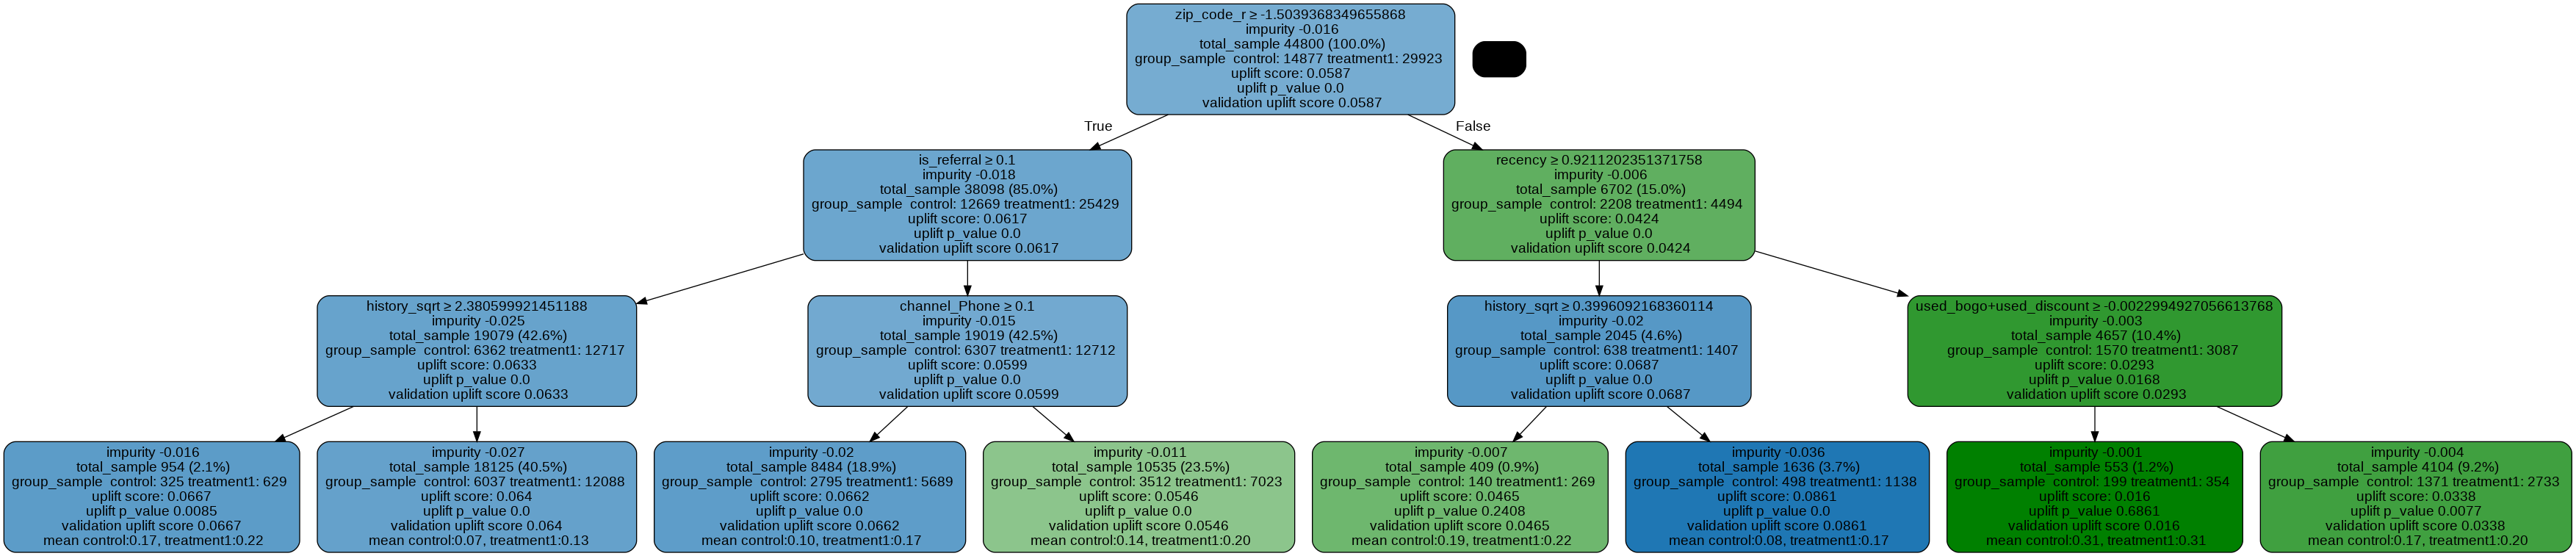

In [51]:
uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control', random_state=42)

uplift_model.fit(X_train,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train.values)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

In [52]:
uplift_tree_string(uplift_model.fitted_uplift_tree, features)

zip_code_r >= -1.5039368349655868?
yes -> is_referral >= 0.1?
		yes -> history_sqrt >= 2.380599921451188?
				yes -> [0.16615384615384615, 0.22257551669316375]
				no  -> [0.06509855888686433, 0.12913633355393778]
		no  -> channel_Phone >= 0.1?
				yes -> [0.10304114490161002, 0.16980137106697135]
				no  -> [0.14464692482915717, 0.19891784137832835]
no  -> recency >= 0.9211202351371758?
		yes -> history_sqrt >= 0.3996092168360114?
				yes -> [0.19285714285714287, 0.21561338289962825]
				no  -> [0.08433734939759036, 0.17486818980667837]
		no  -> used_bogo+used_discount >= -0.0022994927056613768?
				yes -> [0.31155778894472363, 0.3050847457627119]
				no  -> [0.16703136396790663, 0.20160995243322358]


Интересно, что первое разбиение идёт по искуственному признаку: zip_code_r >= -1.50, те - сельская местность (Rural), или нет.

На втором уровне - две группы c uplift = 0.06 для не сельской местности и 0.04 для сельской, причём p_value = 0.0 для обеих групп (те мала вероятность случайности различий).

    Не сельская группа разбивается по признаку is_referral: для перешедших по реферральной ссылке uplift = 0.063, а  для оставшихся - 0.06. p_value = 0.0 для обеих групп.
    
    Сельская группа разбивается по признаку recency (давность последней покупки). Разделение даёт uplift = 0.06 для тех, кто давно не совершал покупок (> 9 мес.) и uplift = 0.029 остальных, p_value для этой группы чуть больше, но остаётся достаточно низким (около 0.02)
    
        Не сельская группа перешедших по реферральной ссылке разбивается по признаку history_sqrt >= 2.38 (сумма покупки, мб накопительная?). Для тех, у кого сумма покупки больше примерно 200 $, uplift = 0.066, для остальных - 0.064, p_value остаётся низким.

        Не сельская группа перешедших не по рефферальной ссылке делится по признаку канала: телефон или нет. Если телефон - uplift = 0.066, если нет - 0.054, p_value = 0.0.
        
        Сельская группа, давно не совершавшая покупок также делится по признаку history_sqrt > 0.39 (несколько меньше 100 $). В группе с большей суммой uplift = 0.047 но p_value = 0.24, у оставшихся - 0.086.
        
        Сельская группа, недавно совершившая покупку делится по принципу: used_bogo+used_discount>-0.00 (т.е. те, кто используют хотя бы одно из). Для тех, кто пользуется акциями - uplift=0.016, но p_value=0.68, для остальных uplift=0.034/
        
        И на последнем уровне разбиения:
            8 групп: 
                - не сельская, перешедая по рферральной ссылке, с достаточно большой суммой покупки (около 200): uplift = 0.067
                - не сельская, перешедая по рферральной ссылке, с не очень большой суммой покупки: uplift = 0.064
                - не сельская, перешедшая не по реферральной ссылке, коммуницирующая по телефону: uplift = 0.066
                - не сельская, перешедшая не по реферральной ссылке, коммуницирующая не по телефону, uplift=0.054
                - сельская, давно (более около 9 мес) не совершавшая покупок, с суммой покупок чуть больше 25 процентиля, uplift=0.047 (p_value=0.24)
                - сельская, давно (более около 9 мес) не совершавшая покупок, с суммой покупок около 25 процентиля или меньше: uplift=0.086 (самая благоприятная для воздействия группа)
                - сельская, недавно совершавшая покупку, пользующаяся акциями: uplift=0.68 (но здесь наиболее высокое p_value=0.69)
                - сельская, недавно совершавшая покупку, не пользующаяся акциями: uplift=0.034
               
Т.е. признаки, использующиеся для разбиения - почтовый код, канал привлечения, время последней покупки и сумма.

__8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift:__

> 1) сделать прогноз и получить uplift для тестовой выборки 

In [54]:
uplift_sm = sm.predict(X_val)
uplift_sm

array([0.02325764, 0.03976101, 0.03412126, ..., 0.02764845, 0.02120813,
       0.02679891])

> 2) отсортировать тестовую выборку по uplift по убыванию 

In [55]:
df_val = pd.DataFrame({
    'conversion': y_val,
    'uplift': uplift_sm,
    'treat': treat_val
}).sort_values('uplift', axis=0, ascending=False).reset_index(drop=True)
df_val

,conversion,uplift,treat
0,0,0.061443,0
1,1,0.061293,1
2,0,0.060611,0
3,0,0.060529,1
4,0,0.060345,1
...,...,...,...
19195,0,0.016345,0
19196,0,0.016299,1
19197,0,0.016299,1
19198,0,0.016299,1


> 3) разбить на децили (pandas qcut вам в помощь) 

In [56]:
bins = pd.qcut(range(df_val.shape[0]), q=10, retbins=True)
bins = bins[-1].astype('int')
bins

array([    0,  1919,  3839,  5759,  7679,  9599, 11519, 13439, 15359,
       17279, 19199])

In [57]:
df_dec = df_val.groupby(pd.qcut(range(df_val.shape[0]), 10))[['treat', 'conversion']].agg('sum')
df_dec

,treat,conversion
"(-0.001, 1919.9]",1293,510
"(1919.9, 3839.8]",1250,394
"(3839.8, 5759.7]",1259,324
"(5759.7, 7679.6]",1269,310
"(7679.6, 9599.5]",1295,290
"(9599.5, 11519.4]",1297,261
"(11519.4, 13439.3]",1271,243
"(13439.3, 15359.2]",1271,197
"(15359.2, 17279.1]",1273,182
"(17279.1, 19199.0]",1293,100


> 4) для каждого дециля посчитать среднюю conversion

In [58]:
# это кривовато, но работает
df_dec['response_rate_treat'] = [df_val.iloc[bins[x]:bins[x+1]].loc[(df_val.treat == 1)].conversion.mean()
                                 for x in range(len(bins)-1)]
df_dec['response_rate_control'] = [df_val.iloc[bins[x]:bins[x+1]].loc[(df_val.treat == 0)].conversion.mean()
                                   for x in range(len(bins)-1)]
df_dec['uplift'] = df_dec['response_rate_treat'] - df_dec['response_rate_control']

In [59]:
df_dec

,treat,conversion,response_rate_treat,response_rate_control,uplift
"(-0.001, 1919.9]",1293,510,0.303944,0.185304,0.118641
"(1919.9, 3839.8]",1250,394,0.236800,0.147761,0.089039
"(3839.8, 5759.7]",1259,324,0.201908,0.105740,0.096168
"(5759.7, 7679.6]",1269,310,0.174941,0.135177,0.039764
"(7679.6, 9599.5]",1295,290,0.172973,0.104000,0.068973
"(9599.5, 11519.4]",1297,261,0.154202,0.099518,0.054684
"(11519.4, 13439.3]",1271,243,0.144768,0.090909,0.053859
"(13439.3, 15359.2]",1271,197,0.111723,0.084746,0.026977
"(15359.2, 17279.1]",1273,182,0.116261,0.052550,0.063711
"(17279.1, 19199.0]",1293,100,0.068779,0.017572,0.051207


In [60]:
# для проверки
uplift_by_percentile(y_val, uplift_sm, treat_val, 
                     strategy='overall', bins=10,
                     total=True, std=True)

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1293,627,0.303944,0.186603,0.117341,0.012791,0.015559,0.020142
10-20,1250,670,0.236800,0.146269,0.090531,0.012024,0.013652,0.018192
20-30,1259,661,0.201747,0.105900,0.095847,0.011310,0.011969,0.016467
30-40,1269,651,0.174941,0.135177,0.039764,0.010665,0.013401,0.017126
40-50,1295,625,0.173745,0.104000,0.069745,0.010529,0.012210,0.016123
50-60,1297,623,0.153431,0.099518,0.053913,0.010007,0.011993,0.015620
60-70,1271,649,0.144768,0.090909,0.053859,0.009870,0.011285,0.014992
70-80,1271,649,0.111723,0.084746,0.026977,0.008836,0.010932,0.014057
80-90,1273,647,0.116261,0.052550,0.063711,0.008984,0.008772,0.012556


__9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево__

In [61]:
uplift_RF = UpliftRandomForestClassifier(n_estimators=2, max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control', random_state=42)
uplift_RF.fit(X_train,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train.values)

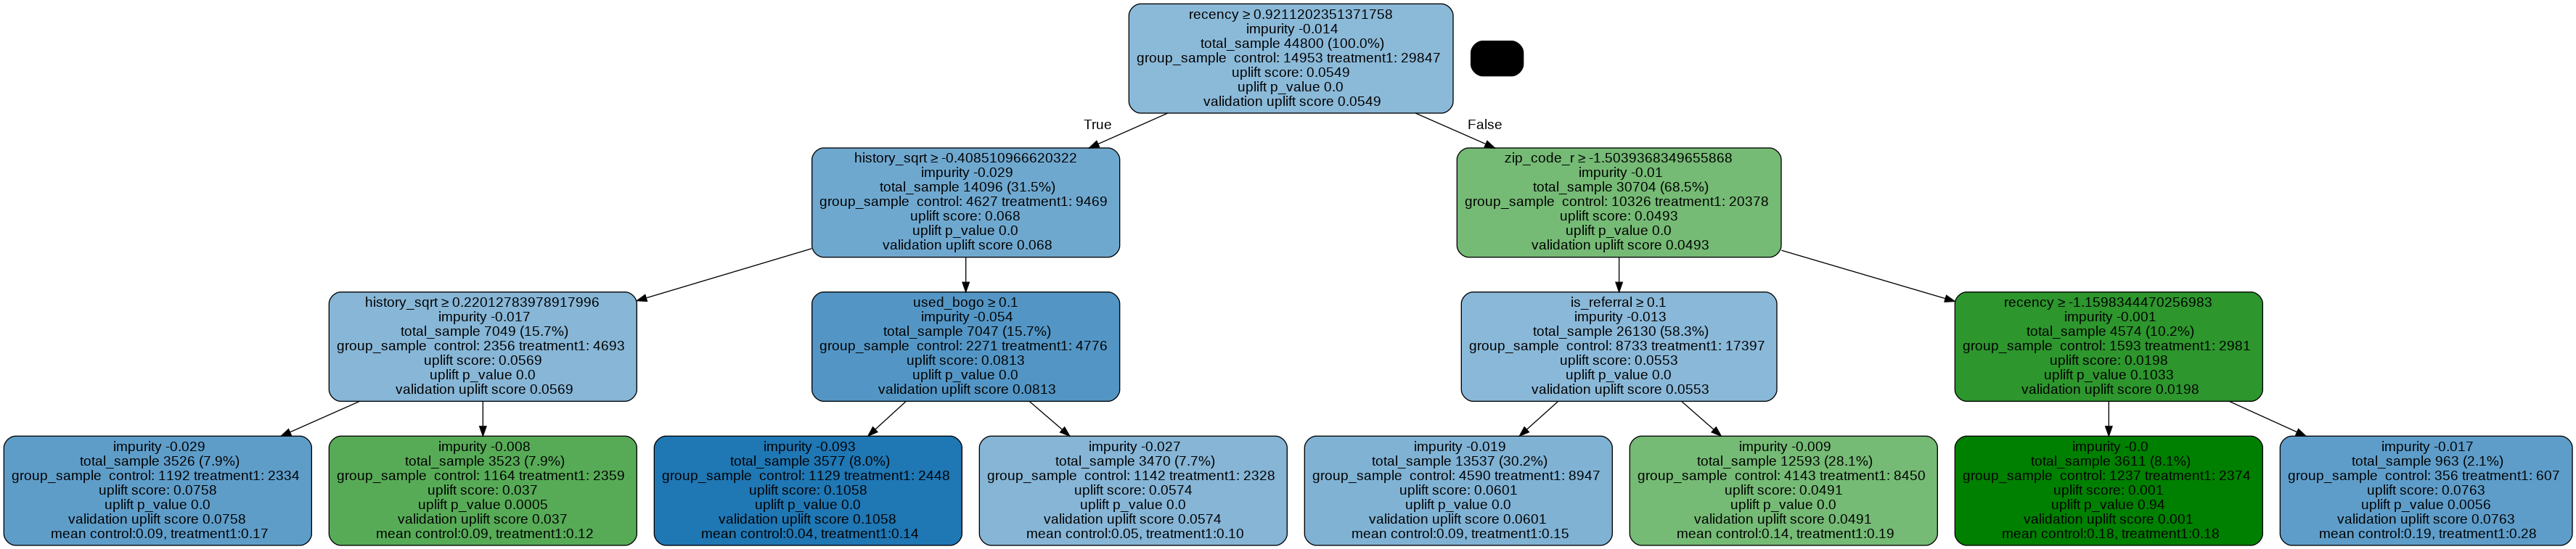

In [62]:
uplift_tree_0 = uplift_RF.uplift_forest[0]
graph = uplift_tree_plot(uplift_tree_0.fitted_uplift_tree, features)
Image(graph.create_png())

In [63]:
uplift_tree_string(uplift_tree_0.fitted_uplift_tree, features)

recency >= 0.9211202351371758?
yes -> history_sqrt >= -0.408510966620322?
		yes -> history_sqrt >= 0.22012783978917996?
				yes -> [0.08976510067114093, 0.1662382176520994]
				no  -> [0.08505154639175258, 0.12123781263247138]
		no  -> used_bogo >= 0.1?
				yes -> [0.03631532329495128, 0.14338235294117646]
				no  -> [0.04816112084063047, 0.10438144329896908]
no  -> zip_code_r >= -1.5039368349655868?
		yes -> is_referral >= 0.1?
				yes -> [0.08976034858387799, 0.15021795015088857]
				no  -> [0.14458122133719528, 0.1932544378698225]
		no  -> recency >= -1.1598344470256983?
				yes -> [0.18431689571544058, 0.18449873631002528]
				no  -> [0.19382022471910113, 0.2784184514003295]


Первым идёт разбиение по давности последней покупки: recency > 9 мес - uplift=0.068, для оставшихся - 0.049.

    Сделавшие покупку давно - разбиваются по history_sqrt > -0.4 (примерно второй квартиль), в истинной ветке uplift=0.057, в ложной - 0.08.
    Сделавшие покупку недавно разбиваются на группы: не сельская местность, uplift=0.055 и сельская uplift=0.02
        Сделавшие покупку давно и с не самой маленькой суммой - снова разбиваются по сумме покупок: history_sqrt > 0.22/
        Сделавшие покупку давно и с маленькой суммой - разбиваются на тех, кто использовал bogo и тех, кто нет.
        Сделавшие покупку недавно и живущие не в сельской местности - разбиваются по признаку is_referral.
        Сделавшие покупку недавно из сельской местности - по признаку давности покупки recency>-0.15 (больше 5 месяцев)
        
        В итоге - 8 групп:
        - Сделавшие покупку больше 9 месяцев назад на не самую маленькую сумму и даже на достаточно большую сумму образуют группу с uplift = 0.075 (достаточно перспективная).
        - Сделавшие покупку больше 9 месяцев назад на не самую маленькую сумму но и на не достаточно большую - uplift 0.037.
        - Сделавшие покупку больше 9 месяцев назад, но на не очень большую сумму и использовавшие bogo - uplift 0.105 (наиболее перспективные из всех).
        - Сделавшие покупку больше 9 месяцев назад, но на не очень большую сумму и не использовавшие bogo: uplift = 0.05.
        - Сделавшие покупку менее, чем 9 месяцев назад, живущие не в сельской местности и перешедшие по реферральной ссылке - uplift=0.06
        - Сделавшие покупку менее, чем 9 месяцев назад, живущие не в сельской местности и не перешедшие по реферральной ссылке - uplift=0.049
        - Сделавшие покупку более, чем 5 месяцев назад, но менее, чем 9, живущие в сельской местности - uplift=0.001 (самые не перспективные), но p_value здесь близко к 1.
        - Сделавшие покупку менее чем 5 месяцев назад, живущие в сельской местности - uplift=0.076 (достаточно перспективные)

Т.е. признаки, используемые для разбиения - практически те же самые, что и в одиночном дереве, но немного в другом порядке.